In [1]:
#install facenet-pytorch
!pip install facenet-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 68.9 MB/s eta 0:00:00


In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

workers = 0 if os.name == 'nt' else 4

In [3]:
torch.cuda.is_available()

True

In [4]:
# Determine if an nvidia GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [5]:
#mtcnn module
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device)

In [6]:
#resnet module
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

  0%|          | 0.00/107M [00:00<?, ?B/s]

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
# Define imshow function 
def imgshow(title="", image = None, size = 6):
    if image.any():
      w, h = image.shape[0], image.shape[1]
      aspect_ratio = w/h
      plt.figure(figsize=(size * aspect_ratio,size))
      plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      plt.title(title)
    else:
      print("Image not found")

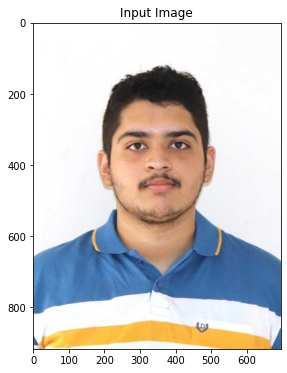

In [9]:
image=cv2.imread("Shrikrish.jpeg")
imgshow("Input Image",image)

**APPLYING MTCNN OF INPUT IMAGE**

In [10]:
#MTCNN Facial Detection
x_aligned, prob = mtcnn(image, return_prob=True)
if x_aligned is not None:
  print('Face detected with probability: {:8f}'.format(prob))

Face detected with probability: 0.999992


In [11]:
#MTCNN Cropped facial image
from facenet_pytorch import extract_face
boxes,probs,points=mtcnn.detect(image,landmarks=True)
im=extract_face(image,boxes[0])

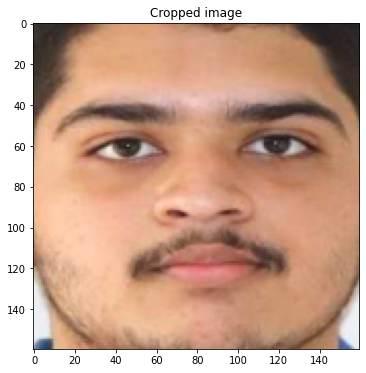

In [12]:
imgshow("Cropped image",im.permute(1,2,0).numpy().astype('uint8'))

In [13]:
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, extract_face
mtcnn = MTCNN(keep_all=True)
boxes, probs, points = mtcnn.detect(image, landmarks=True)
 # Draw boxes and save faces
img_draw = Image.fromarray(image)
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
  draw.rectangle(box.tolist(), width=5)
  for p in point:
    draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10,fill='green')
    extract_face(image, box, save_path='detected_face_{}.png'.format(i))

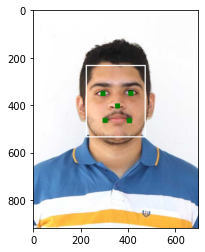

In [14]:
#plot the annoted image with key facial features
plt.imshow(cv2.cvtColor(np.array(img_draw),cv2.COLOR_BGR2RGB))
mtcnn_image=im.permute(1,2,0).numpy().astype('uint8')

MTCNN with 2-Face Image

In [ ]:
#MTCNN with two person images
two_image=cv2.imread('2_face.jpg')
imgshow("MultiFace image",two_image)

In [17]:
#MTCNN Cropped facial image
from facenet_pytorch import extract_face
boxes,probs,points=mtcnn.detect(two_image,landmarks=True)

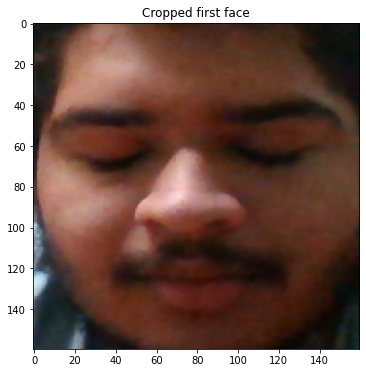

In [18]:
face_one_im=extract_face(two_image,boxes[0],save_path="detected_image_{}.png".format(3))
imgshow("Cropped first face",face_one_im.permute(1,2,0).numpy().astype('uint8'))

In [ ]:
face_two_im=extract_face(two_image,boxes[1])
imgshow("Cropped second face",face_two_im.permute(1,2,0).numpy().astype('uint8'))
second_mtcnn_image=face_two_im.permute(1,2,0).numpy().astype('uint8')

In [20]:
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, extract_face
mtcnn = MTCNN(keep_all=True) #multiple images
boxes, probs, points = mtcnn.detect(two_image, landmarks=True)
 # Draw boxes and save faces
img_draw = Image.fromarray(two_image)
draw = ImageDraw.Draw(img_draw)
for i, (box, point) in enumerate(zip(boxes, points)):
  draw.rectangle(box.tolist(), width=5)
  for p in point:
    draw.rectangle((p - 10).tolist() + (p + 10).tolist(), width=10,fill='green')
    #extract_face(image, box, save_path='detected_face_{}.png'.format(i))

In [ ]:
#plot the annoted image with key facial features
plt.imshow(cv2.cvtColor(np.array(img_draw),cv2.COLOR_BGR2RGB))

**APPLYING DLIB TO THE CROPPED IMAGE**

In [22]:
!pip install dlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
import dlib

In [24]:
# Download facial landmarks
!wget https://moderncomputervision.s3.eu-west-2.amazonaws.com/shape_predictor_68_face_landmarks.dat

--2023-03-03 19:43:23--  https://moderncomputervision.s3.eu-west-2.amazonaws.com/shape_predictor_68_face_landmarks.dat
Resolving moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)... 52.95.149.98
Connecting to moderncomputervision.s3.eu-west-2.amazonaws.com (moderncomputervision.s3.eu-west-2.amazonaws.com)|52.95.149.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/x-www-form-urlencoded]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M  14.5MB/s    in 8.1s    

2023-03-03 19:43:32 (11.8 MB/s) - ‘shape_predictor_68_face_landmarks.dat’ saved [99693937/99693937]



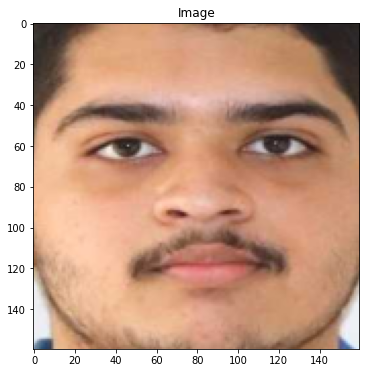

In [25]:
imgshow("Image",mtcnn_image)

In [26]:
mtcnn_image=cv2.cvtColor(mtcnn_image,cv2.COLOR_BGR2RGB)

In [27]:
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

gray = cv2.cvtColor(mtcnn_image, cv2.COLOR_RGB2GRAY)
    
# Get faces 
rects = detector(gray,1)

boxes=[r.rect for r in rects]


# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(mtcnn_image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    #Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(mtcnn_image, (x, y), 2, (0, 255, 0), -1)

Text(0.5, 1.0, 'MTCNN AND DLIB OPERATION IMAGE')

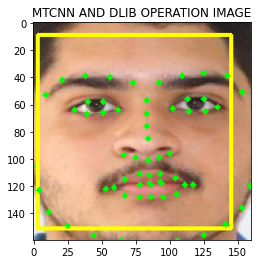

In [28]:
plt.imshow(mtcnn_image)
plt.title("MTCNN AND DLIB OPERATION IMAGE")

In [ ]:
#another image example with dlib and mtcnn
p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
predictor = dlib.shape_predictor(p)

second_mtcnn_image=cv2.cvtColor(second_mtcnn_image,cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(second_mtcnn_image, cv2.COLOR_RGB2GRAY)
    
# Get faces 
rects = detector(gray, 1)

boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray, boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(second_mtcnn_image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    #Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(second_mtcnn_image, (x, y), 2, (0, 255, 0), -1)
        
plt.imshow(second_mtcnn_image)
plt.title("MTCNN AND DLIB OPERATION IMAGE")

In [30]:
#Applying dlib without mtcnn to the input image
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

image = cv2.imread('Shrikrish.jpeg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
# Get faces 
rects = detector(gray, 1)
boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    # Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)


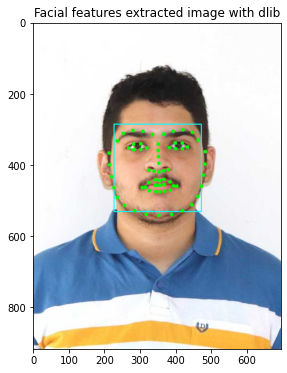

In [31]:
imgshow("Facial features extracted image with dlib",image)

dlib with multiple faces 

In [32]:
#Applying dlib without mtcnn to the input image
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

image = cv2.imread('2_face.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
# Get faces 
rects = detector(gray, 1)
boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    # Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(image, (x, y), 5, (0, 255, 0), -1)


In [ ]:
imgshow("Muthiple Facial features extracted image with dlib",image)

Extracting Eye and mouth area of interset from the image

Doing for the image of 4 states


1.   Open eye and Open Mouth Image
2.   Open eye and Closed Mouth Image
3.   Closed eye and Open Mouth Image
4.   Closed eye and Closed Mouth Image



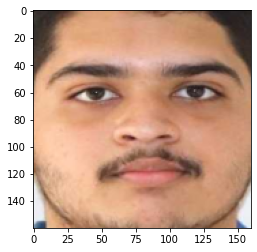

In [34]:
input_image=cv2.imread("detected_face_0.png") #from mtcnn
plt.imshow(input_image)

In [35]:
#marking eye and mouth features
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

gray = cv2.cvtColor(input_image, cv2.COLOR_RGB2GRAY)
    
# Get faces 
rects = detector(gray,1)

boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(input_image, (x, y), (x + w, y + h), (255, 255, 0), 2)
    #Draw on our image, all the finded cordinate points (x,y) 

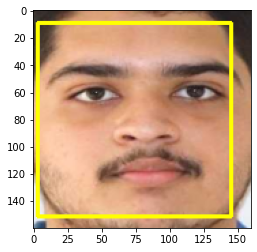

In [36]:
plt.imshow(input_image)

In [37]:
eye_idx=list(np.arange(36,48))

mouth_idx=list(np.arange(60,68))

In [38]:
key_features=np.concatenate((shape[eye_idx],shape[mouth_idx]))

In [39]:
for (x,y) in key_features:
  cv2.circle(input_image, (x, y), 2, (0, 255, 0), -1)

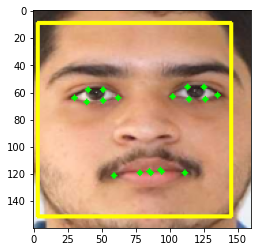

In [40]:
plt.imshow(input_image)

In [41]:
len(key_features)

20

In [42]:
def dist(p1,p2):
    dist=sum([(i-j)**2 for i,j in zip(p1,p2)]) **0.5
    return dist

In [43]:
#calculate ear
#left eye distances
p2_p6_l=dist(key_features[1],key_features[5])
p3_p5_l=dist(key_features[2],key_features[4])
p1_p4_l=dist(key_features[0],key_features[3])
#right eye distances
p2_p6_r=dist(key_features[7],key_features[11])
p3_p5_r=dist(key_features[8],key_features[10])
p1_p4_r=dist(key_features[6],key_features[9])
left_ear=(p2_p6_l+p3_p5_l)/(2.0 * p1_p4_l)
right_ear=(p2_p6_r+p3_p5_r)/(2.0 * p1_p4_r)
ear_open_1=(left_ear+right_ear)/2.0
print(ear_open_1)

0.27038505000669005


In [45]:
#calculate closed mouth aspect ratio
p62_p68=dist(key_features[13],key_features[19])
p63_p67=dist(key_features[14],key_features[18])
p64_p66=dist(key_features[15],key_features[17])
mouth_h=dist(key_features[12],key_features[16])
mouth_v=(p62_p68+p63_p67+p64_p66)/3
mar_close_1=mouth_v/mouth_h
print(mar_close_1)

0.018117547506621468


In [44]:
out=input_image.copy()

Text(0.5, 1.0, 'Open Eye and Closed Mouth Image')

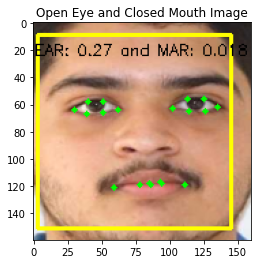

In [46]:
cv2.putText(out,f"EAR: {round(ear_open_1,3)} and MAR: {round(mar_close_1,3)}",(1,24),cv2.FONT_HERSHEY_SIMPLEX,0.37,(0,0,0),1)
plt.imshow(out)
plt.title("Open Eye and Closed Mouth Image")

In [47]:
image_1=cv2.imread("Image-1.jpeg")
#MTCNN Cropped facial image
from facenet_pytorch import extract_face
boxes,probs,points=mtcnn.detect(image_1,landmarks=True)
im_1=extract_face(image_1, boxes[0], save_path='detected_face_{}.png'.format(1))

In [48]:
image_2=cv2.imread("Image-2.jpeg")
boxes,probs,points=mtcnn.detect(image_2,landmarks=True)
im_2=extract_face(image_2, boxes[0], save_path='detected_face_{}.png'.format(2))

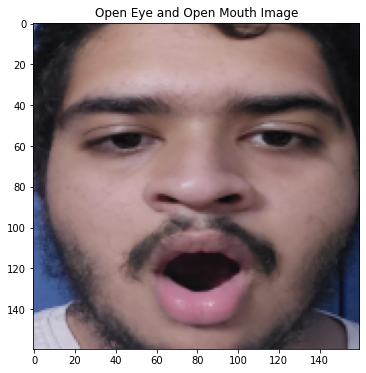

In [49]:
imgshow("Open Eye and Open Mouth Image",im_1.permute(1,2,0).numpy().astype('uint8'))
img_1=im_1.permute(1,2,0).numpy().astype('uint8')

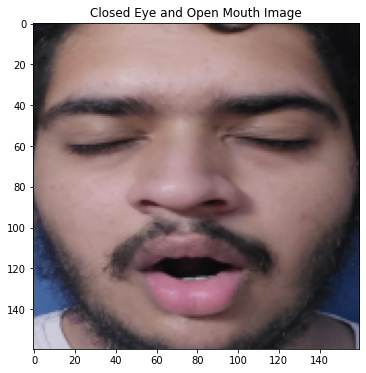

In [50]:
imgshow("Closed Eye and Open Mouth Image",im_2.permute(1,2,0).numpy().astype('uint8'))
img_2=im_2.permute(1,2,0).numpy().astype('uint8')

In [51]:
#open eyes and open mouth image
image_1=cv2.imread("detected_face_1.png")

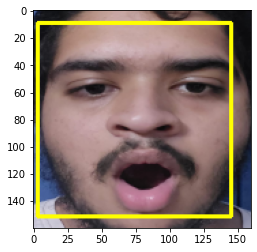

In [52]:
#marking eye and mouth features
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

gray = cv2.cvtColor(image_1, cv2.COLOR_RGB2GRAY)
    
# Get faces 
rects = detector(gray,1)

boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(image_1, (x, y), (x + w, y + h), (255, 255, 0), 2)
    #Draw on our image, all the finded cordinate points (x,y) 

plt.imshow(image_1)

Text(0.5, 1.0, 'Key features')

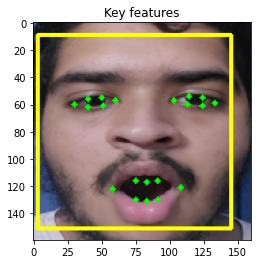

In [53]:
eye_idx=list(np.arange(36,48))
mouth_idx=list(np.arange(60,68))
key_features=np.concatenate((shape[eye_idx],shape[mouth_idx]))
for (x,y) in key_features:
  cv2.circle(image_1, (x, y), 2, (0, 255, 0), -1)
plt.imshow(image_1)
plt.title("Key features")

In [54]:
#calculate ear
#left eye distances
p2_p6_l=dist(key_features[1],key_features[5])
p3_p5_l=dist(key_features[2],key_features[4])
p1_p4_l=dist(key_features[0],key_features[3])
#right eye distances
p2_p6_r=dist(key_features[7],key_features[11])
p3_p5_r=dist(key_features[8],key_features[10])
p1_p4_r=dist(key_features[6],key_features[9])
left_ear=(p2_p6_l+p3_p5_l)/(2.0 * p1_p4_l)
right_ear=(p2_p6_r+p3_p5_r)/(2.0 * p1_p4_r)
ear_open_2=(left_ear+right_ear)/2.0
print(ear_open_2)

0.20065665997300003


In [55]:
#calculate open mouth aspect ratio
p62_p68=dist(key_features[13],key_features[19])
p63_p67=dist(key_features[14],key_features[18])
p64_p66=dist(key_features[15],key_features[17])
mouth_h=dist(key_features[12],key_features[16])
mouth_v=(p62_p68+p63_p67+p64_p66)/3
mar_open_1=mouth_v/mouth_h
print(mar_open_1)

0.27994401679440195


Text(0.5, 1.0, 'Open Eye and Open Mouth Image')

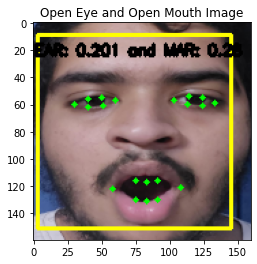

In [56]:
out=image_1.copy()
cv2.putText(out,f"EAR: {round(ear_open_2,3)} and MAR: {round(mar_open_1,3)}",(1,24),cv2.FONT_HERSHEY_SIMPLEX,0.36,(0,0,0),2)
plt.imshow(out)
plt.title("Open Eye and Open Mouth Image")

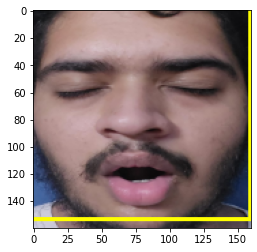

In [57]:
#closed eye and open mouth image
image_ceom=cv2.imread("detected_face_2.png")
#marking eye and mouth features
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

gray = cv2.cvtColor(image_ceom, cv2.COLOR_RGB2GRAY)
    
# Get faces 
rects = detector(gray,1)

boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(image_ceom, (x, y), (x + w, y + h), (255, 255, 0), 2)
    #Draw on our image, all the finded cordinate points (x,y) 

plt.imshow(image_ceom)

Text(0.5, 1.0, 'Key features')

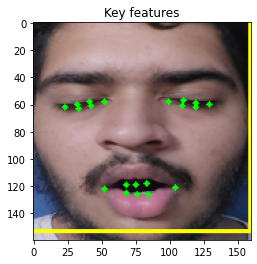

In [58]:
eye_idx=list(np.arange(36,48))
mouth_idx=list(np.arange(60,68))
key_features=np.concatenate((shape[eye_idx],shape[mouth_idx]))
for (x,y) in key_features:
  cv2.circle(image_ceom, (x, y), 2, (0, 255, 0), -1)
plt.imshow(image_ceom)
plt.title("Key features")

In [59]:
#calculate ear
#left eye distances
p2_p6_l=dist(key_features[1],key_features[5])
p3_p5_l=dist(key_features[2],key_features[4])
p1_p4_l=dist(key_features[0],key_features[3])
#right eye distances
p2_p6_r=dist(key_features[7],key_features[11])
p3_p5_r=dist(key_features[8],key_features[10])
p1_p4_r=dist(key_features[6],key_features[9])
left_ear=(p2_p6_l+p3_p5_l)/(2.0 * p1_p4_l)
right_ear=(p2_p6_r+p3_p5_r)/(2.0 * p1_p4_r)
ear_close_1=(left_ear+right_ear)/2.0
print(ear_close_1)

0.11323841582280031


In [60]:
#calculate open mouth aspect ratio
p62_p68=dist(key_features[13],key_features[19])
p63_p67=dist(key_features[14],key_features[18])
p64_p66=dist(key_features[15],key_features[17])
mouth_h=dist(key_features[12],key_features[16])
mouth_v=(p62_p68+p63_p67+p64_p66)/3
mar_open_2=mouth_v/mouth_h
print(mar_open_2)

0.1354449926553316


Text(0.5, 1.0, 'Closed Eye and Open Mouth Image')

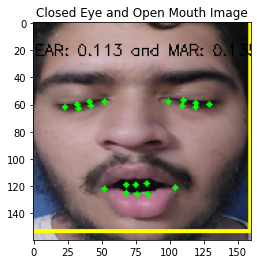

In [61]:
out=image_ceom.copy()
cv2.putText(out,f"EAR: {round(ear_close_1,3)} and MAR: {round(mar_open_2,3)}",(1,24),cv2.FONT_HERSHEY_SIMPLEX,0.37,(0,0,0),1)
plt.imshow(out)
plt.title("Closed Eye and Open Mouth Image")

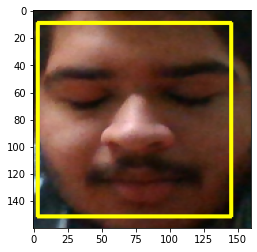

In [62]:
#Closed Eye and Closed Mouth image
image_cecm=cv2.imread("detected_image_3.png")
#marking eye and mouth features
from imutils import face_utils
detector = dlib.cnn_face_detection_model_v1("/content/mmod_human_face_detector.dat")
p = "shape_predictor_68_face_landmarks.dat"
#detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)

gray = cv2.cvtColor(image_cecm, cv2.COLOR_RGB2GRAY)
    
# Get faces 
rects = detector(gray,1)

boxes=[r.rect for r in rects]

# For each detected face, find the landmark.
for (i, rect) in enumerate(rects):
    # Make the prediction and transfom it to numpy array
    shape = predictor(gray,boxes[i])
    shape = face_utils.shape_to_np(shape)
    (x, y, w, h) = face_utils.rect_to_bb(boxes[i])
    cv2.rectangle(image_cecm, (x, y), (x + w, y + h), (255, 255, 0), 2)
    #Draw on our image, all the finded cordinate points (x,y) 

plt.imshow(image_cecm)

Text(0.5, 1.0, 'Key features')

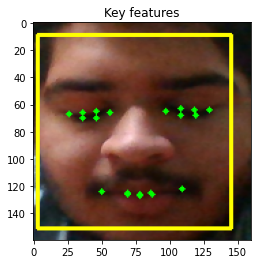

In [63]:
eye_idx=list(np.arange(36,48))
mouth_idx=list(np.arange(60,68))
key_features=np.concatenate((shape[eye_idx],shape[mouth_idx]))
for (x,y) in key_features:
  cv2.circle(image_cecm, (x, y), 2, (0, 255, 0), -1)
plt.imshow(image_cecm)
plt.title("Key features")

In [64]:
#calculate ear
#left eye distances
p2_p6_l=dist(key_features[1],key_features[5])
p3_p5_l=dist(key_features[2],key_features[4])
p1_p4_l=dist(key_features[0],key_features[3])
#right eye distances
p2_p6_r=dist(key_features[7],key_features[11])
p3_p5_r=dist(key_features[8],key_features[10])
p1_p4_r=dist(key_features[6],key_features[9])
left_ear=(p2_p6_l+p3_p5_l)/(2.0 * p1_p4_l)
right_ear=(p2_p6_r+p3_p5_r)/(2.0 * p1_p4_r)
ear_close_2=(left_ear+right_ear)/2.0
print(ear_close_2)

0.14619785430642734


In [65]:
#calculate closed mouth aspect ratio
p62_p68=dist(key_features[13],key_features[19])
p63_p67=dist(key_features[14],key_features[18])
p64_p66=dist(key_features[15],key_features[17])
mouth_h=dist(key_features[12],key_features[16])
mouth_v=(p62_p68+p63_p67+p64_p66)/3
mar_close_2=mouth_v/mouth_h
print(mar_close_2)

0.019278269058262146


Text(0.5, 1.0, 'Closed Eye and Open Mouth Image')

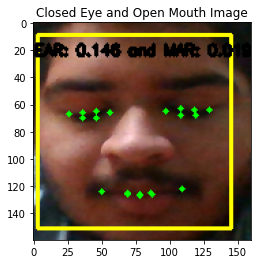

In [66]:
out=image_cecm.copy()
cv2.putText(out,f"EAR: {round(ear_close_2,3)} and MAR: {round(mar_close_2,3)}",(1,24),cv2.FONT_HERSHEY_SIMPLEX,0.36,(0,0,0),2)
plt.imshow(out)
plt.title("Closed Eye and Open Mouth Image")

In [67]:
print("EAR for open eyes is: ",(ear_open_1,ear_open_2))
print("MAR for open mouth is ",(mar_open_1,mar_open_2))
print("EAR for closed eyes is ",(ear_close_1,ear_close_2))
print("MAR for closed eyes is: ",(mar_close_1,mar_close_2))
#we can find minimum of ear/mar for closed eyes/mouth and maximum of ear/mar for open eyes/mouth to get range
ear_open_max=max(ear_open_1,ear_open_2)
ear_close_min=min(ear_close_1,ear_close_2)
mar_open_max=max(mar_open_1,mar_open_2)
mar_close_min=min(mar_close_1,mar_close_2)

EAR for open eyes is:  (0.27038505000669005, 0.20065665997300003)
MAR for open mouth is  (0.27994401679440195, 0.1354449926553316)
EAR for closed eyes is  (0.11323841582280031, 0.14619785430642734)
MAR for closed eyes is:  (0.018117547506621468, 0.019278269058262146)


In [68]:
#threshold ranges for comparision
print("Range of ear is: ",(ear_close_min,ear_open_max))
print("Range of mar is: ",(mar_close_min,mar_open_max))

Range of ear is:  (0.11323841582280031, 0.27038505000669005)
Range of mar is:  (0.018117547506621468, 0.27994401679440195)
